In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import display   #From stack overflow link below
from sklearn.preprocessing import StandardScaler
import pickle

%config InlineBackend.figure_format = 'retina'

#:https://stackoverflow.com/questions/51288869/print-visually-pleasing-dataframes-in-for-loop-in-jupyter-notebook-pandas

/Users/rwilkening/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('./datasets/train.csv')

# <span style = 'color: blue' > Cleaning </span>

**Viewing the DataFrame**

In [3]:
train.shape

(2051, 81)

# Reformatting Columns and Column Names#

**Creating `train_cols` Variable with all the Dataframe Columns:**

In [4]:
train_cols = train.columns

**Making the headers all lower_case**


In [5]:
train.columns = [cols.lower() for cols in train.columns]

**Replace spaces with underscores**


In [6]:
train.columns = [cols.lower().replace(" ", "_") for cols in train.columns]

**Changing the name of `totrms_abv_grd` to `tot_rooms_abv_grd`**


In [7]:
train.rename(columns = {'totrms_abvgrd': 'tot_rooms_abvgrd'}, inplace = True)

**Renaming `lot_frontage` to `lot_frontage_sf`**

In [8]:
train.rename(columns = {'lot_frontage': 'lot_frontage_sf'}, inplace = True)

### Creating Consistency in Column Names

**Changes `area` to `sf`:**

In [9]:
train.columns = [cols.replace('area', 'sf') for cols in train.columns]

**Changes `qc` to `qu`:**

In [10]:
train.columns = [cols.replace('qc', 'qu') for cols in train.columns]

**Changes `qual` to `qu`:**

In [11]:
train.columns = [cols.replace('qual', 'qu') for cols in train.columns]

**Changes `year` to `yr`:**

In [12]:
train.columns = [cols.replace('year', 'yr') for cols in train.columns]

**Adding an underscore after `bsmt` when there wasn't one:**

In [13]:
train.columns = [cols.replace("bsmt", "bsmt_") for cols in train.columns]

**Making sure there's not double underscores when there was already an underscore from fixes made in the above cell:**

In [14]:
train.columns = [cols.replace("__", "_") for cols in train.columns]

**Changes `NoSeWa` to `NoSewr` in Utilities Columns**

In [15]:
train.replace('NoSeWa', 'NoSewr', inplace =True)

**Replaces `RFn` with `Fin` in `garage_finish` columns**

In [16]:
train.replace('RFn', 'Fin', inplace =True)

**Updating the `train_cols` variable:**

In [17]:
train_cols = train.columns

**Checking the Null Values of each Column. Those not in view have 0 nulls:**

In [18]:
train.isnull().sum().sort_values(ascending = False).head(30)

pool_qu            2042
misc_feature       1986
alley              1911
fence              1651
fireplace_qu       1000
lot_frontage_sf     330
garage_finish       114
garage_cond         114
garage_qu           114
garage_yr_blt       114
garage_type         113
bsmt_exposure        58
bsmt_fin_type_2      56
bsmt_fin_type_1      55
bsmt_cond            55
bsmt_qu              55
mas_vnr_type         22
mas_vnr_sf           22
bsmt_half_bath        2
bsmt_full_bath        2
garage_cars           1
garage_sf             1
bsmt_unf_sf           1
bsmt_fin_sf_2         1
total_bsmt_sf         1
bsmt_fin_sf_1         1
overall_cond          0
exterior_2nd          0
exterior_1st          0
roof_matl             0
dtype: int64

**Replacing Nulls in Numeric Columns with the Mean**

Based on Analysis, Data Shows That Replacing Nulls in Numeric Columns is an Appropriate way to Handle Nulls

In [19]:
null_cols = train.columns[train.isnull().any()] #Adapted from stack overflow, see link below

null_df = train[null_cols]  #Creating a dataframe with just columns that have nulls 

num_nulls = null_df._get_numeric_data()  #Extracting Numeric Null Cols 

for col in num_nulls:
    train[col].fillna(train[col].mean(), inplace = True)

#Code for creating `null_cols` adapted from stack overflow:   #Adapted from stackoverflow.com     https://stackoverflow.com/questions/37366717/pandas-print-column-name-with-missing-values
    

**Viewing Non-Numeric Columns with Nulls**

In [20]:
train.isnull().sum().sort_values(ascending = False).head(18)

pool_qu            2042
misc_feature       1986
alley              1911
fence              1651
fireplace_qu       1000
garage_finish       114
garage_qu           114
garage_cond         114
garage_type         113
bsmt_exposure        58
bsmt_fin_type_2      56
bsmt_fin_type_1      55
bsmt_cond            55
bsmt_qu              55
mas_vnr_type         22
street                0
yr_remod/add          0
roof_style            0
dtype: int64

**Removing Houses With Square Footage over 4,000 as Recommended in the Data Dictionary:**

In [21]:
train = train[train['gr_liv_sf'] < 4000]
train.shape

(2049, 81)

**Addressing A Typo:** In the above chart we can see there was a value where the garage was built in "2207", which of course is impossible. Sense we know the data if from yrs 2006-2010, and it'll have little statistical affect if we do it this way, we'll assume it was meant to be 2007.

In [22]:
train[train["garage_yr_blt"] > 2020]["garage_yr_blt"] #Viewing where the location of the typo's cell is
train.at[1699, "garage_yr_blt"] = float(2007) #Changing the cell to assumed correct value. Changing to a float because the rest of the values in the column are float. 

**Assigning Numerical Value to Ordinal Values in Non-Numeric Columns:**

Excellent(Ex) : 5 

Average/Average (TA) : 4 

Good (Gd) : 3 

Fair (Fa) : 2

Poor (Po) : 1

In [23]:
quity_numbers = { 'Ex' : 5 , 'TA' : 4 , 'Gd' : 3 , 'Fa': 2 , 'Po': 1}
train.replace ({
    'heating_qu': quity_numbers, 
    'pool_qu': quity_numbers, 
    'garage_cond': quity_numbers, 
    'garage_qu': quity_numbers, 
    'fireplacequ': quity_numbers, 
    'kitchen_qu': quity_numbers, 
    'bsmt_cond' : quity_numbers, 
    'bsmt_qu': quity_numbers, 
    'exter_cond': quity_numbers, 
    'exter_qu' : quity_numbers
}, inplace=True)

**Dropping Nulls for Newly Transformed Ordinal Columns** (That'll Be Used Latered For Feature Engineering)

In [24]:
train.dropna(subset = ['garage_cars'], axis = 0, inplace = True)
train.dropna(subset = ['total_bsmt_sf'], axis=0, inplace = True)

**Creating a Numerical Columns Variable Called `num_cols`:**

In [25]:
num_cols = train._get_numeric_data()

**Defining Function to Get the Difference Between Two List:**

In [26]:
#Code adapted from GeeksforGeeks.org          https://www.geeksforgeeks.org/python-difference-two-lists/

def get_difference(lst_1, lst_2): 
    dif = (list(set(lst_1) - set(lst_2)))  #Subtracting list 2(sm. list) from list 1(big list)
    return dif

**Creating a Catergorial Columns List Called `cat_cols`:**

In [27]:
cat_cols = get_difference(train_cols, num_cols) #using the get difference function to subtract numerical columns from all the columns 

**Viewing the `cat_cols` Dataframe**

In [28]:
train[cat_cols].head()

lot_config exterior_2nd utilities foundation garage_finish roof_style  \
0    CulDSac      Plywood    AllPub     CBlock           Fin      Gable   
1    CulDSac      VinylSd    AllPub      PConc           Fin      Gable   
2     Inside      VinylSd    AllPub     CBlock           Unf      Gable   
3     Inside      VinylSd    AllPub      PConc           Fin      Gable   
4     Inside      Plywood    AllPub      PConc           Unf      Gable   

  misc_feature alley bsmt_fin_type_1 sale_type  ... mas_vnr_type fireplace_qu  \
0          NaN   NaN             GLQ       WD   ...      BrkFace          NaN   
1          NaN   NaN             GLQ       WD   ...      BrkFace           TA   
2          NaN   NaN             GLQ       WD   ...         None          NaN   
3          NaN   NaN             Unf       WD   ...         None          NaN   
4          NaN   NaN             Unf       WD   ...         None          NaN   

  fence condition_1 land_contour condition_2 land_slope street functional  \
0   NaN        RRAe          Lvl        Norm        Gtl   Pave        Typ   
1   NaN        Norm          Lvl        Norm        Gtl   Pave        Typ   
2   NaN        Norm          Lvl        Norm        Gtl   Pave        Typ   
3   NaN        Norm          Lvl        Norm        Gtl   Pave        Typ   
4   NaN        Norm          Lvl        Norm        Gtl   Pave        Typ   

  exterior_1st  
0      HdBoard  
1      VinylSd  
2      VinylSd  
3      VinylSd  
4      Wd Sdng  

[5 rows x 33 columns]

# <span style = "color:blue" > EDA </span>

---
---
---

**Viewing the yrs this Dataset was Taken From**

In [29]:
print("yrs of houses sold in data:")
print(train['yr_sold'].unique())

yrs of houses sold in data:
[2010 2009 2006 2007 2008]


**Defining a Function that Prints the Columns by Simalities**

In [30]:
prefixes =["bsmt", "sf", "gar", "pool", "exter", "sale", "sold", "bath", "qu", "cond", 'por', 'lot', "roof", "room", "abvgr", "yr"]

def group_prefixes(df, cols_list, prefix_list):
    grouped = []

    for prefixes in prefix_list:
#         print("Columns with '" + prefixes + "' in common:")
#         print("")

        for columns in df.columns:
            if prefixes in columns:
                print(columns)
                grouped.append(columns)
                
                
        print("___")
        
    diff = get_difference(df.columns, grouped)
    
    print("Number of columns NOT grouped:", len(diff))
    print("Columns that are NOT grouped:")
    print("___")
    
    return diff

**Viewing Columns Based on Similiarities**

In [31]:
group_prefixes(train, train_cols, prefixes)

bsmt_qu
bsmt_cond
bsmt_exposure
bsmt_fin_type_1
bsmt_fin_sf_1
bsmt_fin_type_2
bsmt_fin_sf_2
bsmt_unf_sf
total_bsmt_sf
bsmt_full_bath
bsmt_half_bath
___
lot_frontage_sf
lot_sf
mas_vnr_sf
bsmt_fin_sf_1
bsmt_fin_sf_2
bsmt_unf_sf
total_bsmt_sf
1st_flr_sf
2nd_flr_sf
low_qu_fin_sf
gr_liv_sf
garage_sf
wood_deck_sf
open_porch_sf
pool_sf
___
garage_type
garage_yr_blt
garage_finish
garage_cars
garage_sf
garage_qu
garage_cond
___
pool_sf
pool_qu
___
exterior_1st
exterior_2nd
exter_qu
exter_cond
___
sale_type
saleprice
___
mo_sold
yr_sold
___
bsmt_full_bath
bsmt_half_bath
full_bath
half_bath
___
overall_qu
exter_qu
bsmt_qu
heating_qu
low_qu_fin_sf
kitchen_qu
fireplace_qu
garage_qu
pool_qu
___
condition_1
condition_2
overall_cond
exter_cond
bsmt_cond
garage_cond
___
open_porch_sf
enclosed_porch
3ssn_porch
screen_porch
___
lot_frontage_sf
lot_sf
lot_shape
lot_config
___
roof_style
roof_matl
___
bedroom_abvgr
tot_rooms_abvgrd
___
bedroom_abvgr
kitchen_abvgr
tot_rooms_abvgrd
___
yr_built
yr_remod/add


['pid',
 'utilities',
 'foundation',
 'misc_feature',
 'alley',
 'electrical',
 'house_style',
 'neighborhood',
 'bldg_type',
 'heating',
 'ms_zoning',
 'central_air',
 'paved_drive',
 'id',
 'misc_val',
 'mas_vnr_type',
 'fence',
 'land_contour',
 'fireplaces',
 'land_slope',
 'street',
 'ms_subclass',
 'functional']

**Number of Houses Sold Per Yr:**

Number of houses sold:


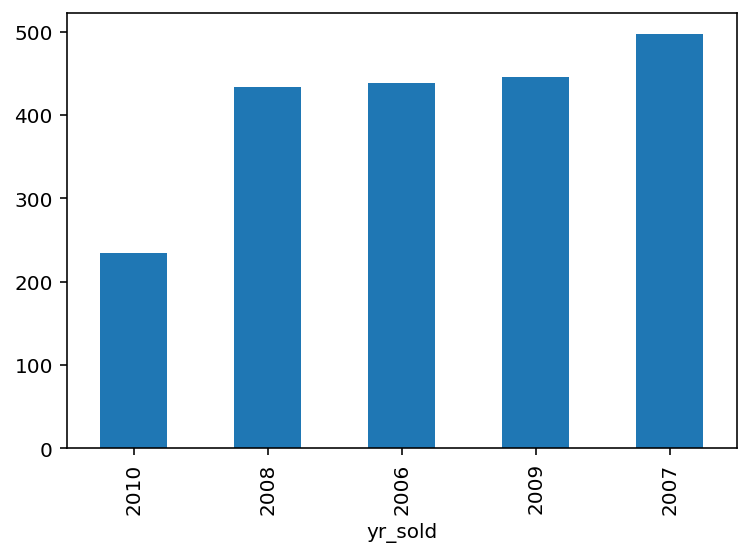

In [32]:
print("Number of houses sold:")
train.groupby('yr_sold')['id'].count().sort_values().plot(kind ='bar');

**Correlation Between Lot Size and Price Excluding Outliers Above 6,000 sq. ft.**

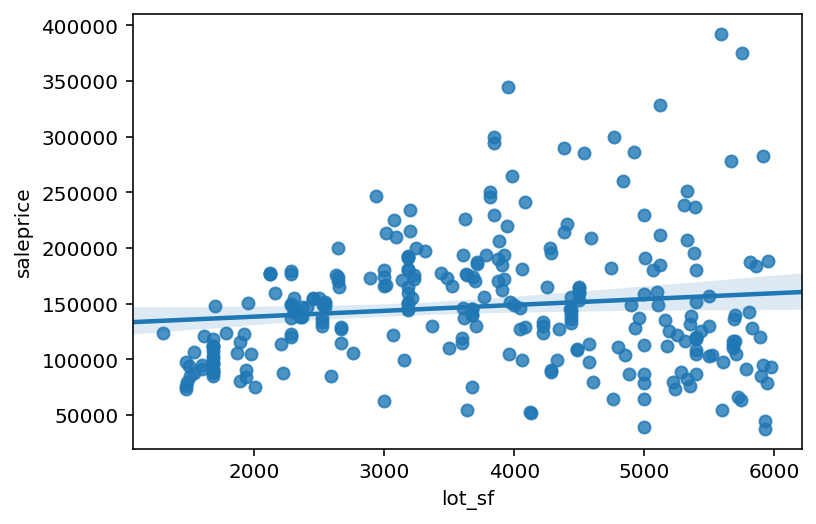

In [33]:
sm_lot = train[train['lot_sf'] < 6000][['lot_sf', 'saleprice']]

sns.regplot(x='lot_sf', y="saleprice", data=sm_lot);

**Correlation Between Number of `garage_car` and `garage_sf`**

-We can resonably get rid of one of the columns because they're redundant

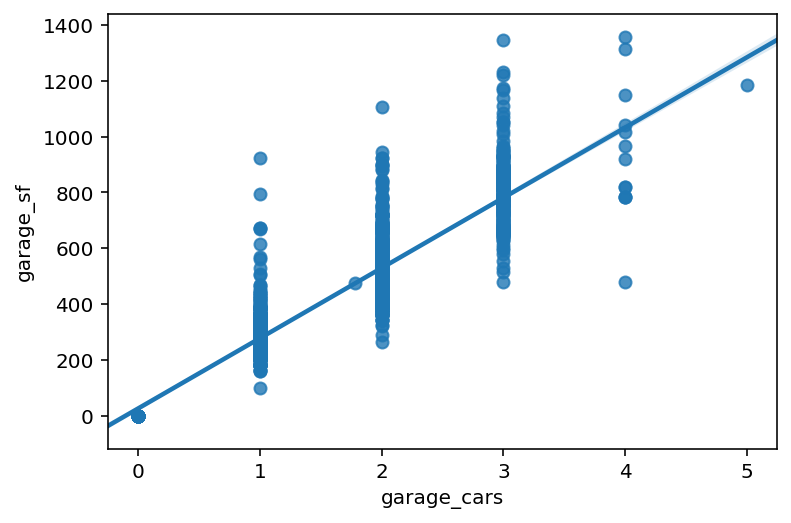

In [34]:
sns.regplot(x='garage_cars', y="garage_sf", data=train);

**Setting Up Columns Correlation to Saleprice:**

In [35]:
#Code adapted from classmate Pete Plass
num_mask =num_cols.drop(columns = ['id', 'pid', 'ms_subclass'])
train_corr = num_mask.corr()
high_corr = train_corr[['saleprice']].sort_values("saleprice", ascending=False).head(15)
high_corr_cols = high_corr.index

**Correlation Between Saleprice and Numerical Columns**

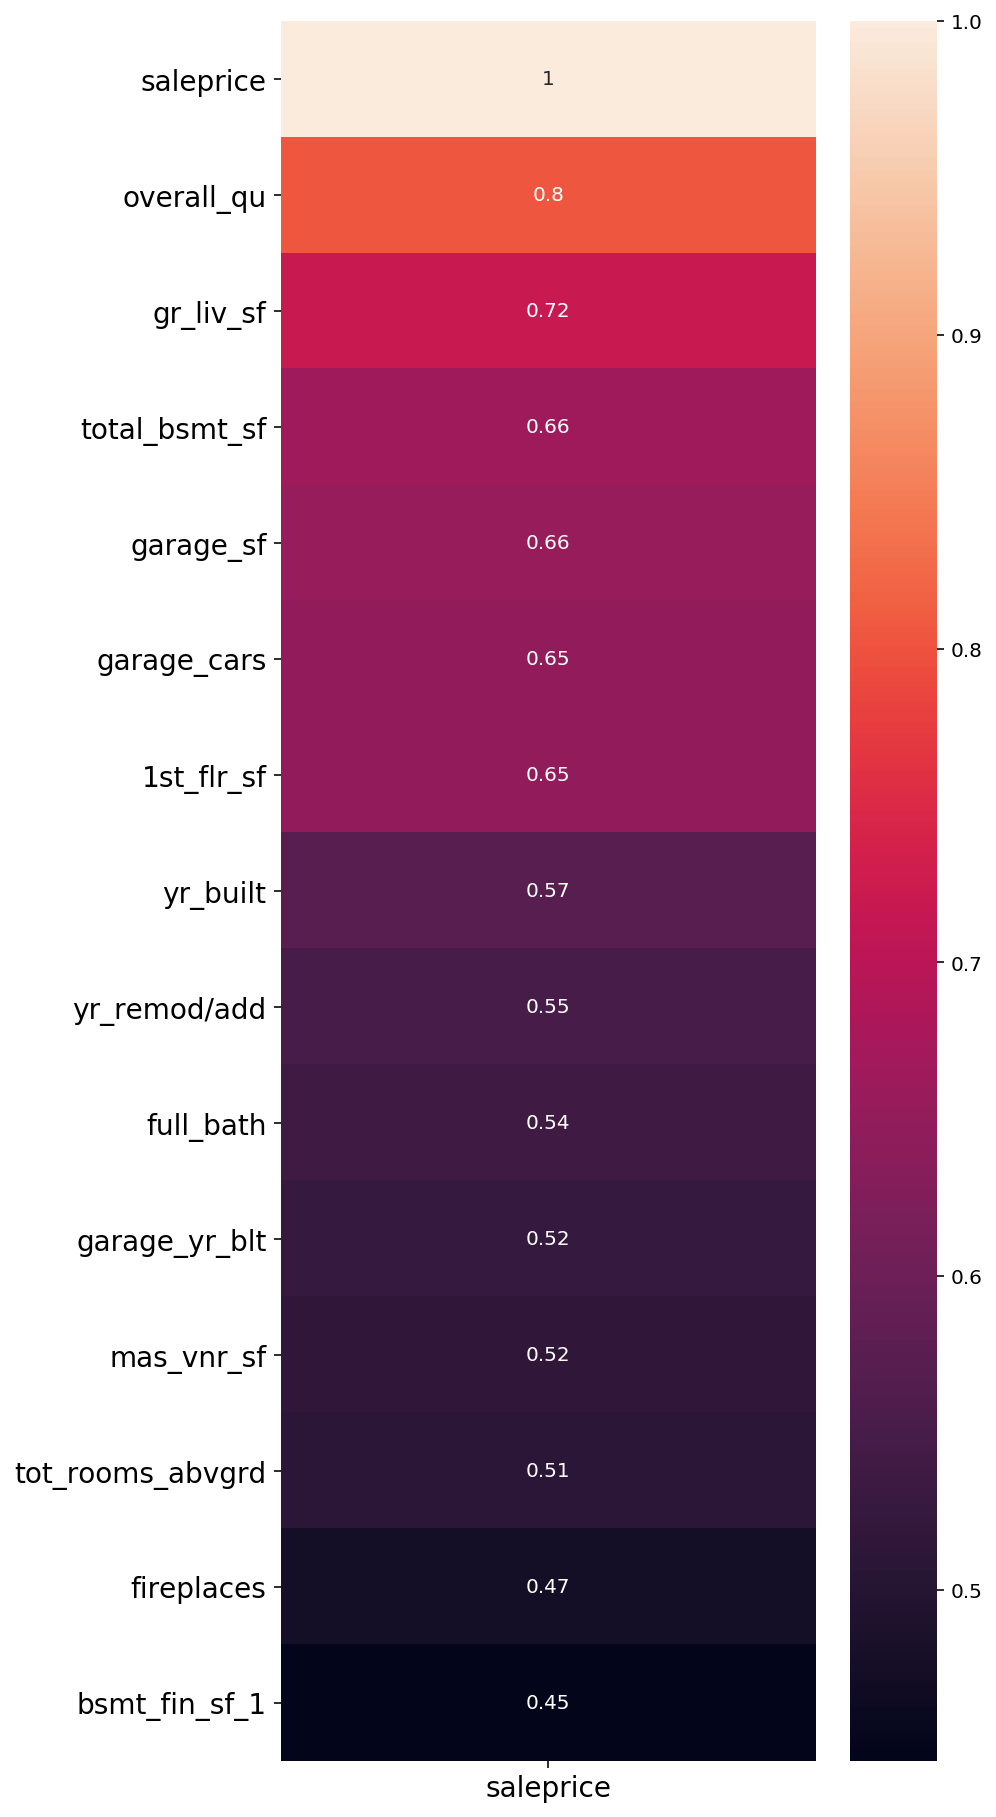

In [36]:
high_corr

plt.figure(figsize= (6,16))
sns.heatmap(high_corr, annot=True);
plt.yticks(size=14);
plt.xticks(size = 14);

**Checking for Outliers in 15 most Correlated Features**

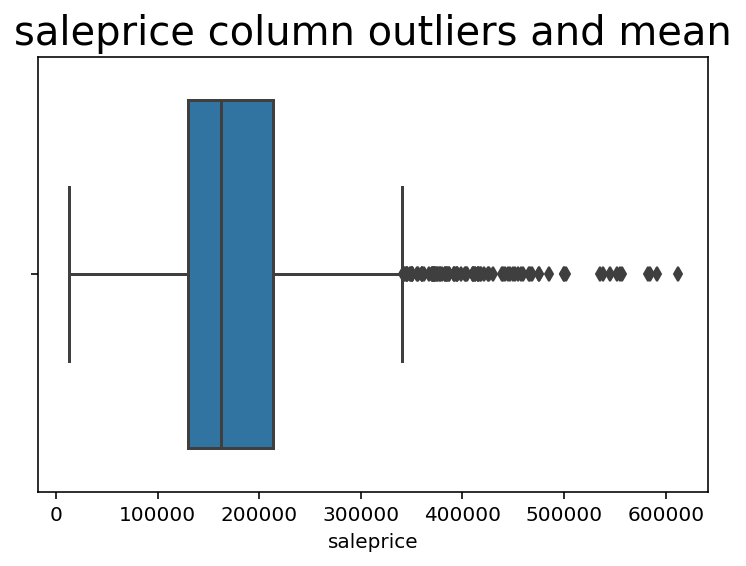

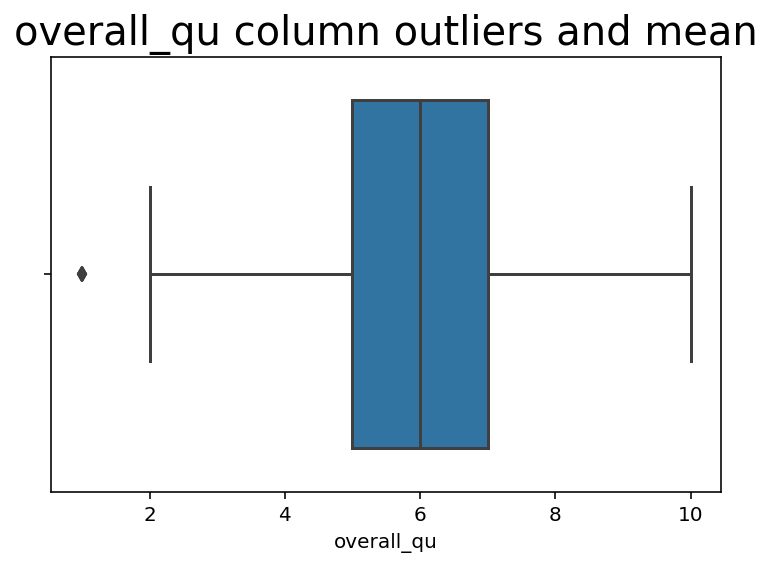

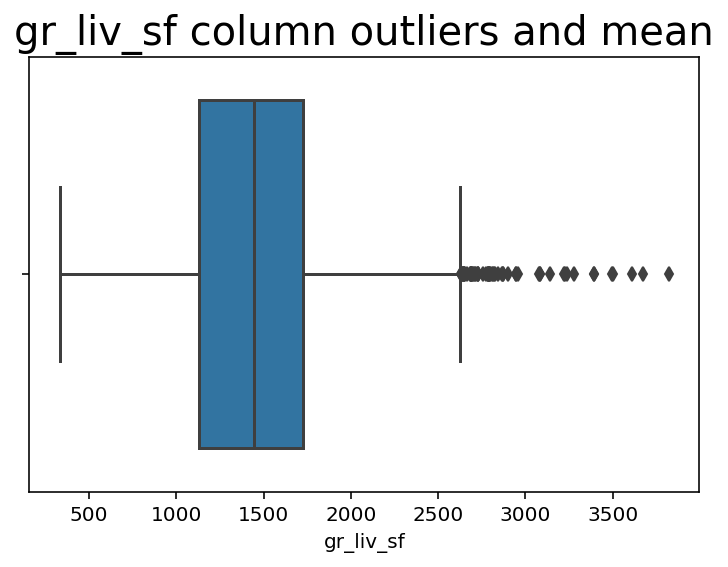

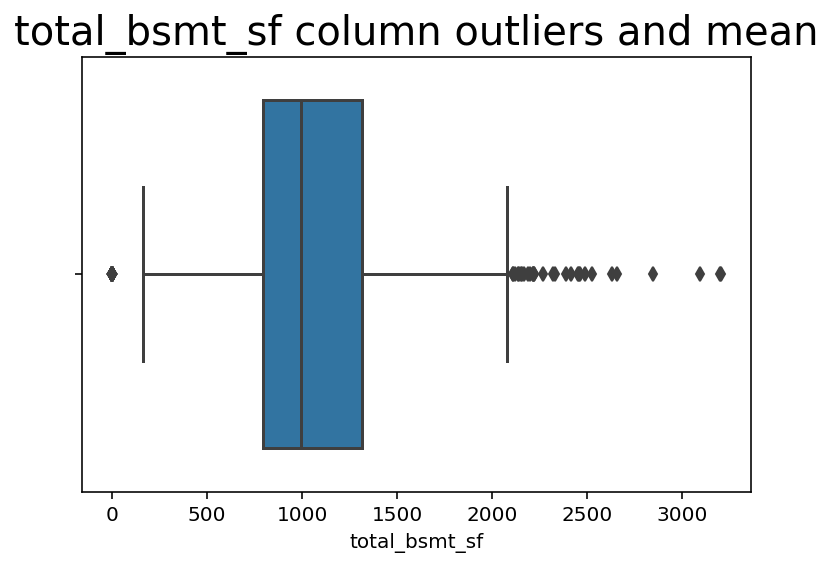

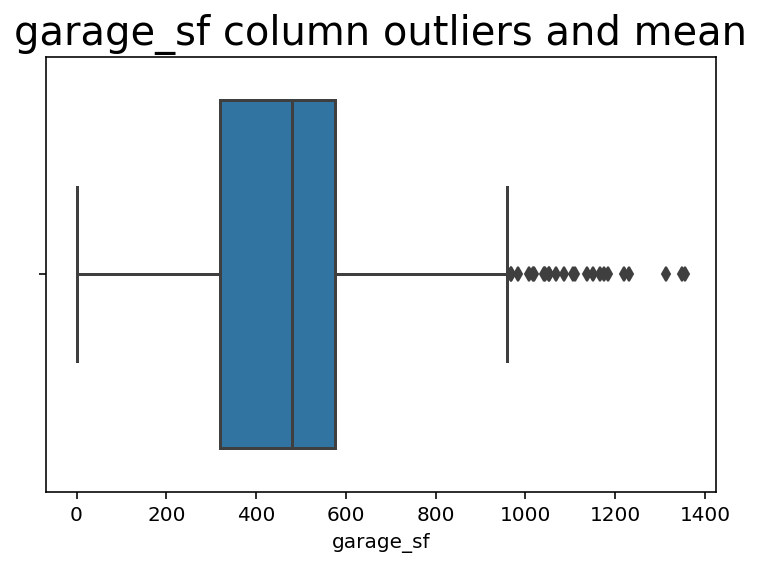

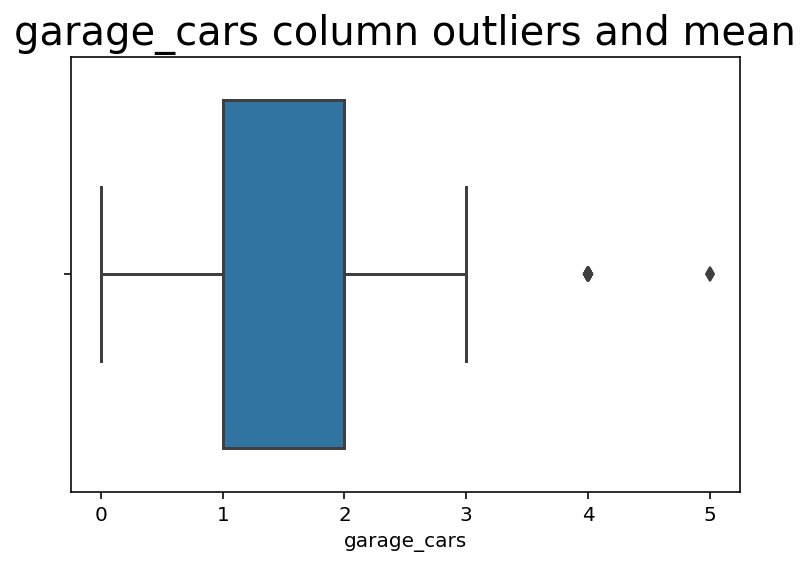

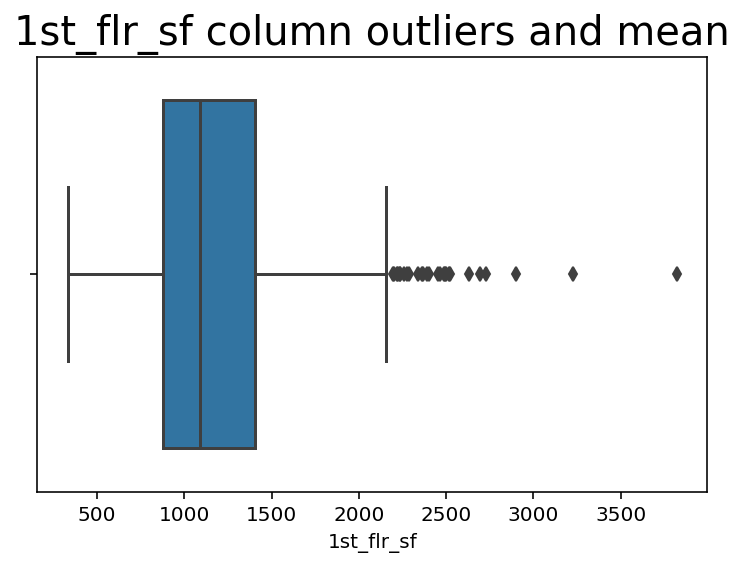

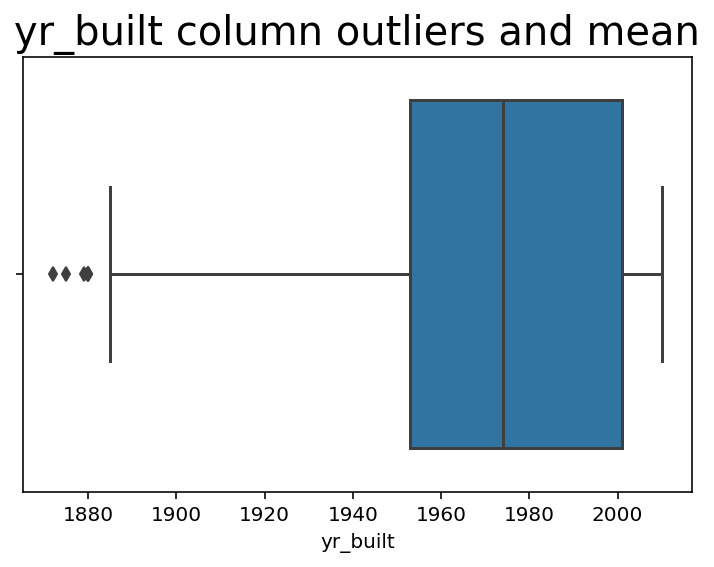

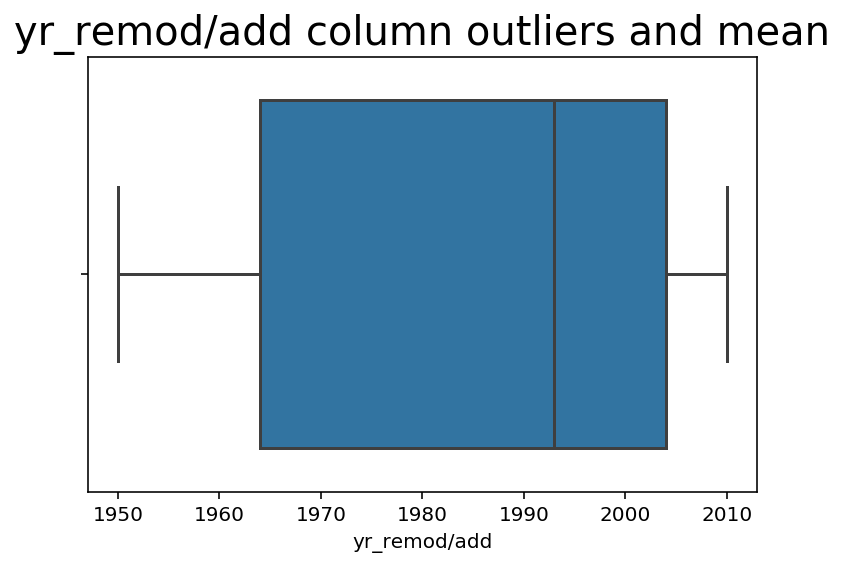

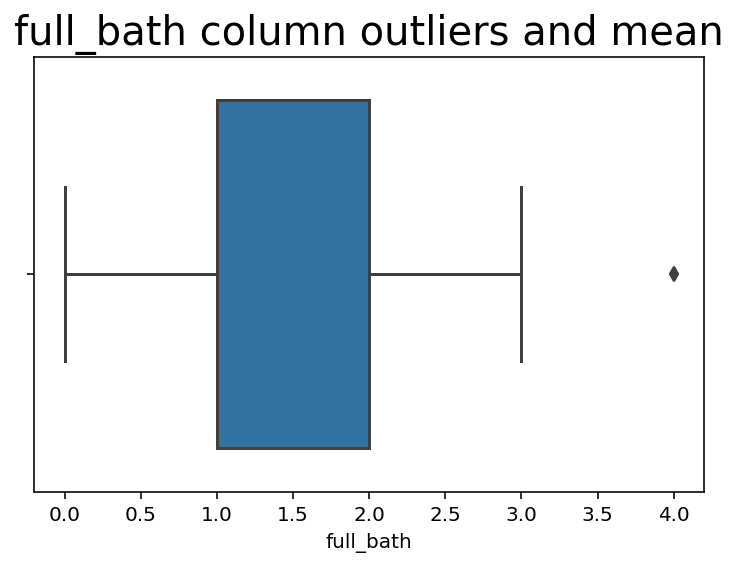

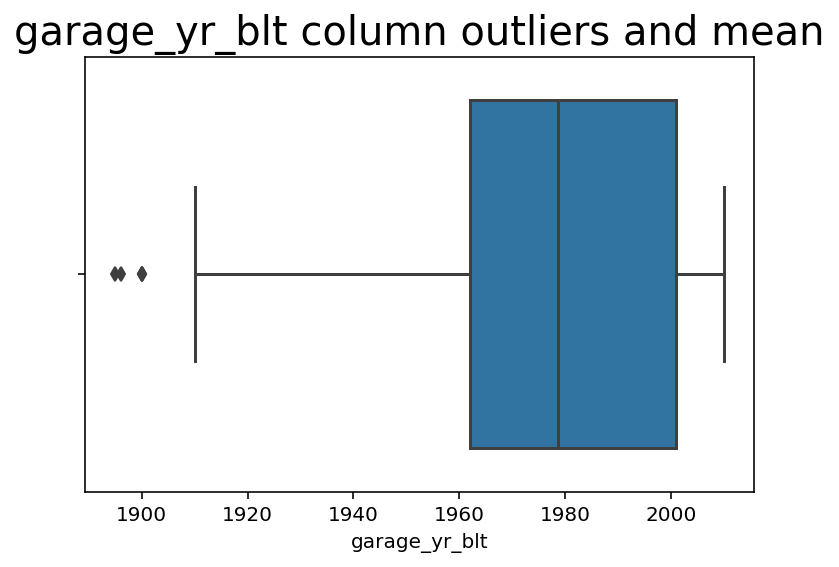

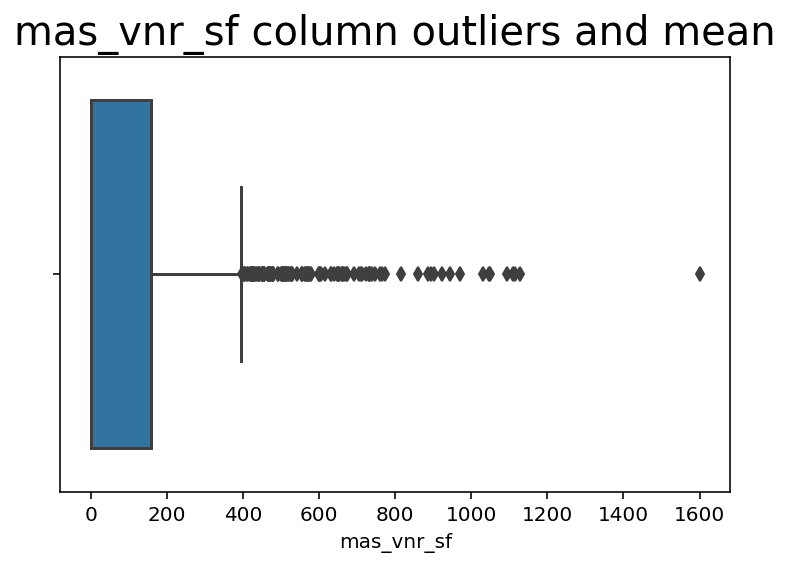

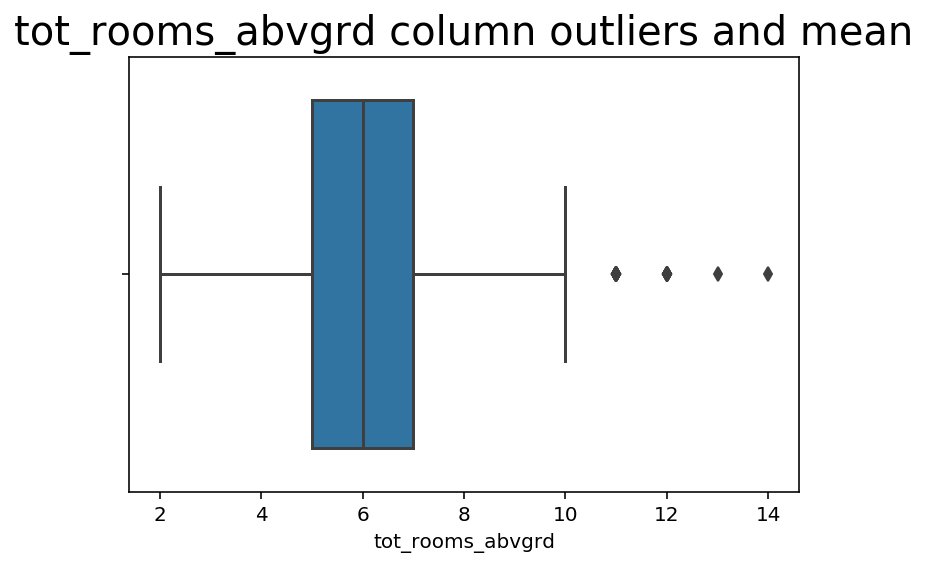

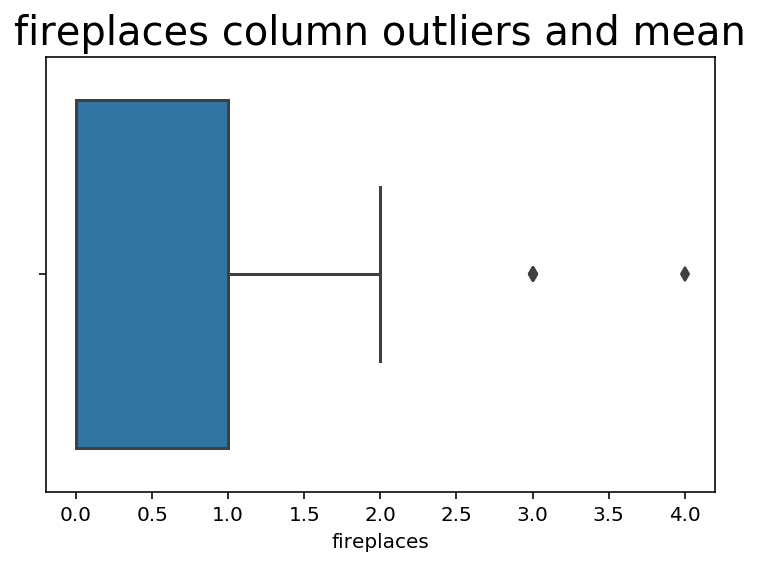

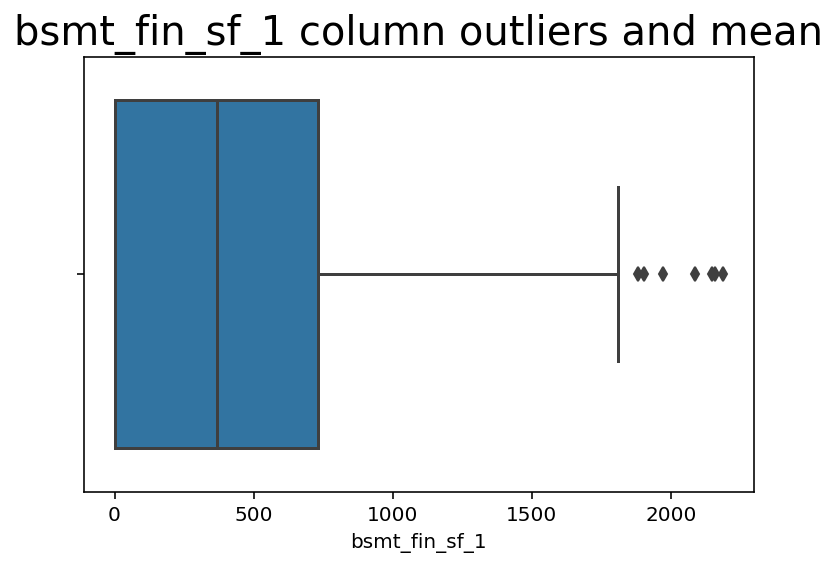

In [37]:
high_corr_df = train[high_corr_cols] #Creating a df with just the highly correlated columns 


for columns in high_corr_df:
    sns.boxplot(x=train[columns]);
    plt.title(f"{columns} column outliers and mean", fontsize = 20);
    plt.show()

**Plot of 15 Most Correlated Columns to `saleprice`**

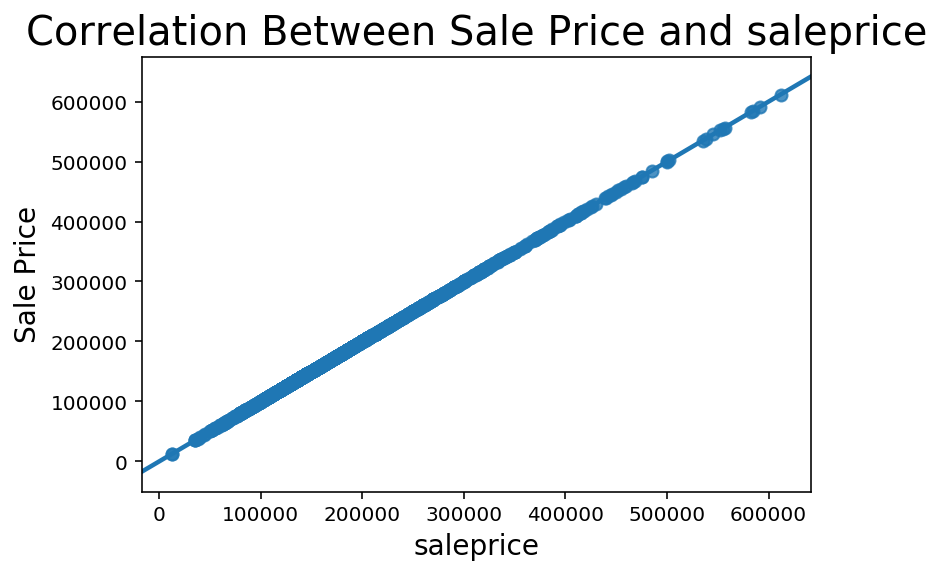

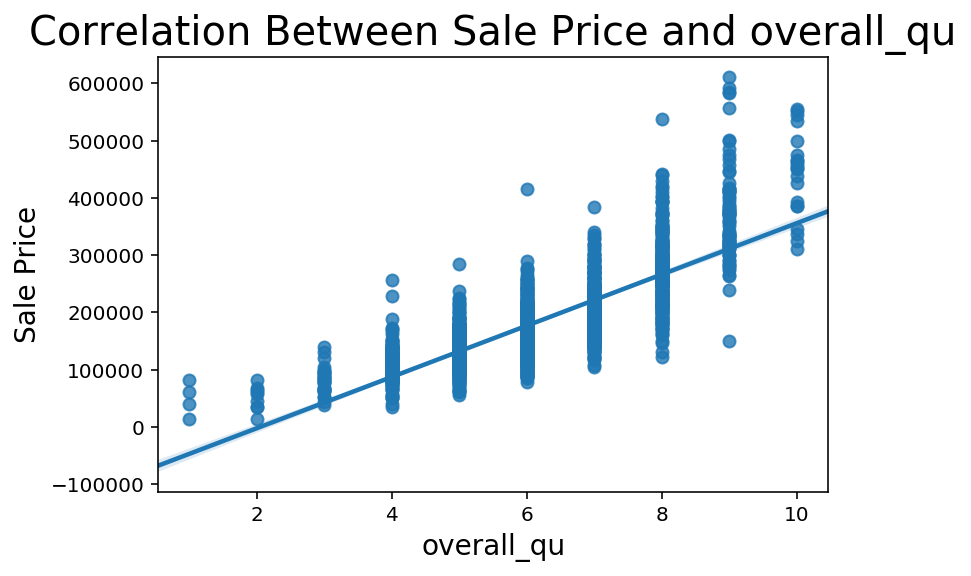

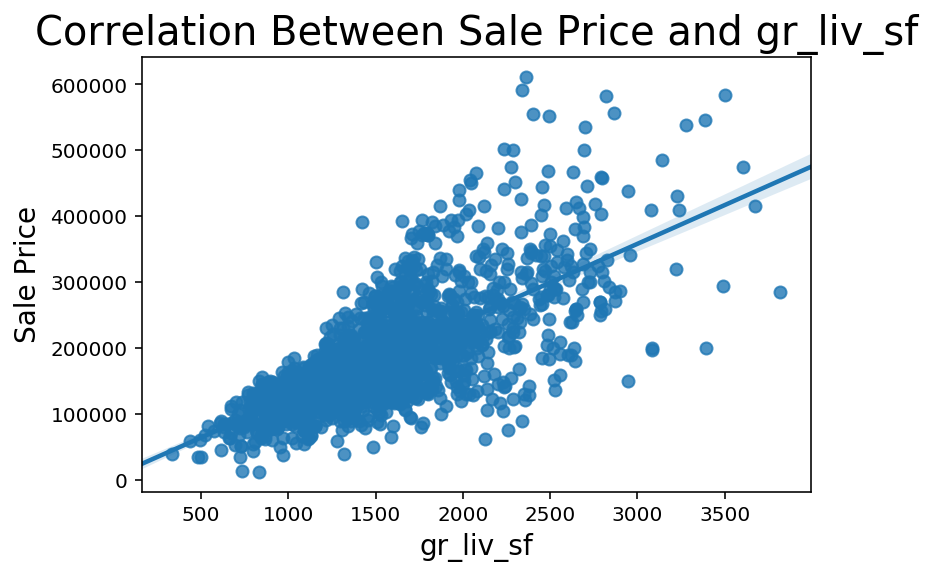

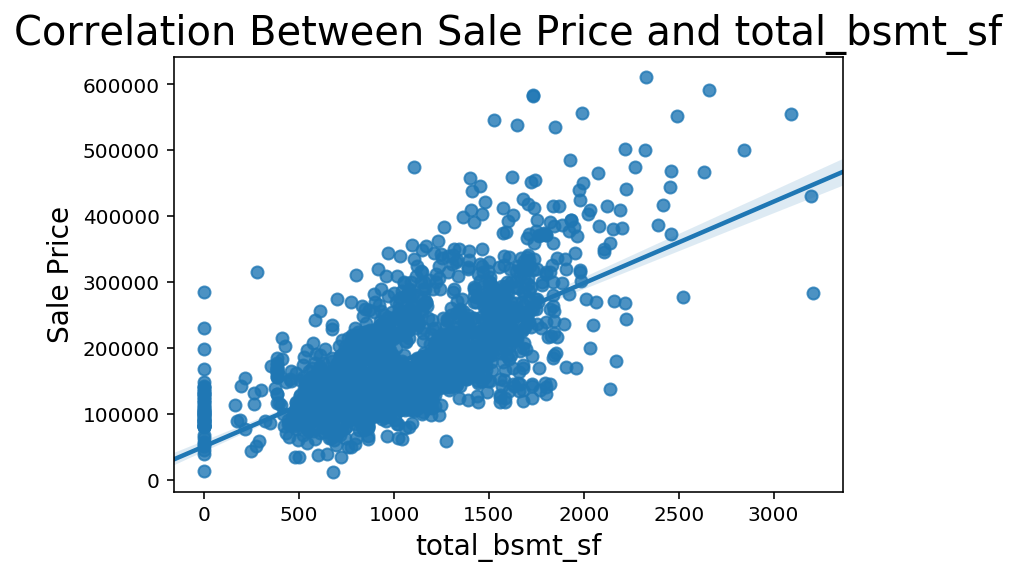

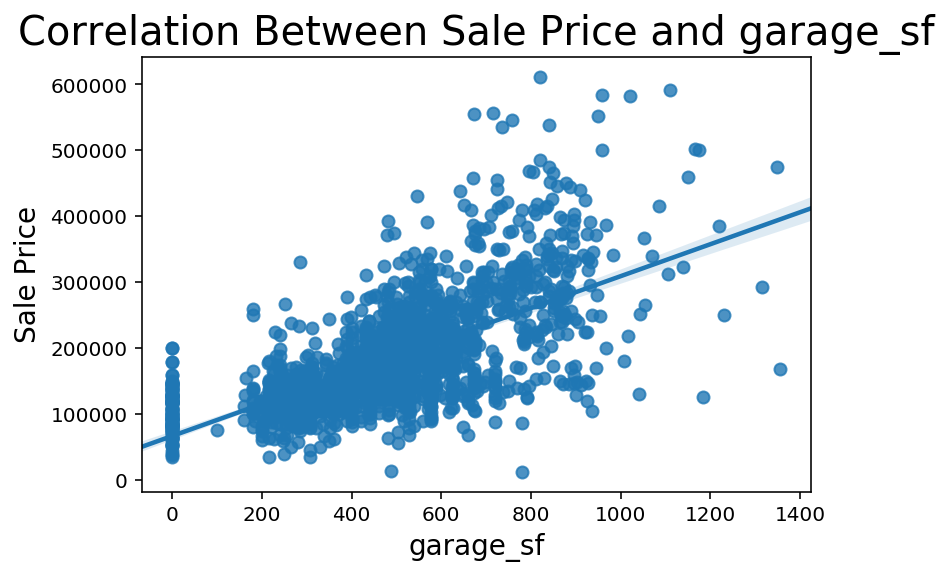

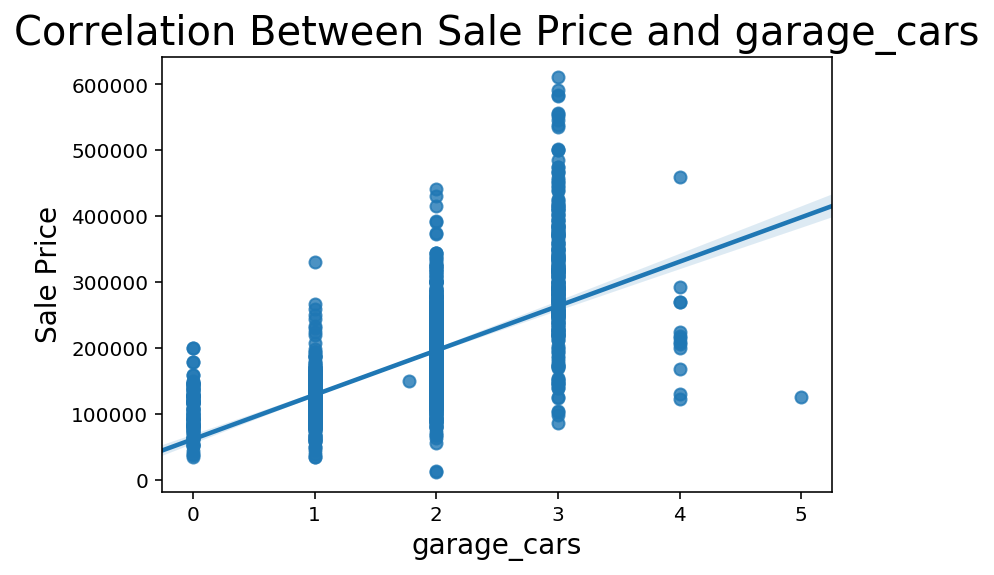

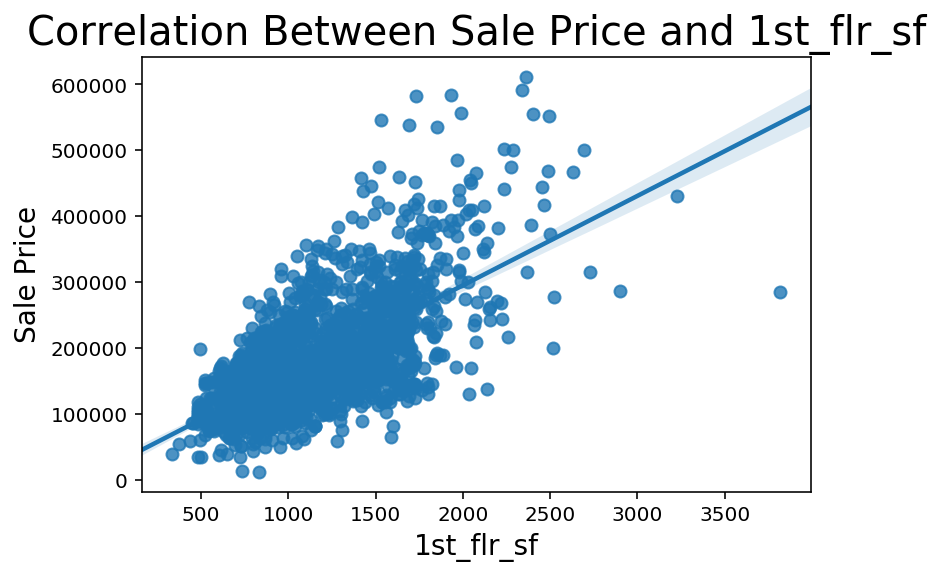

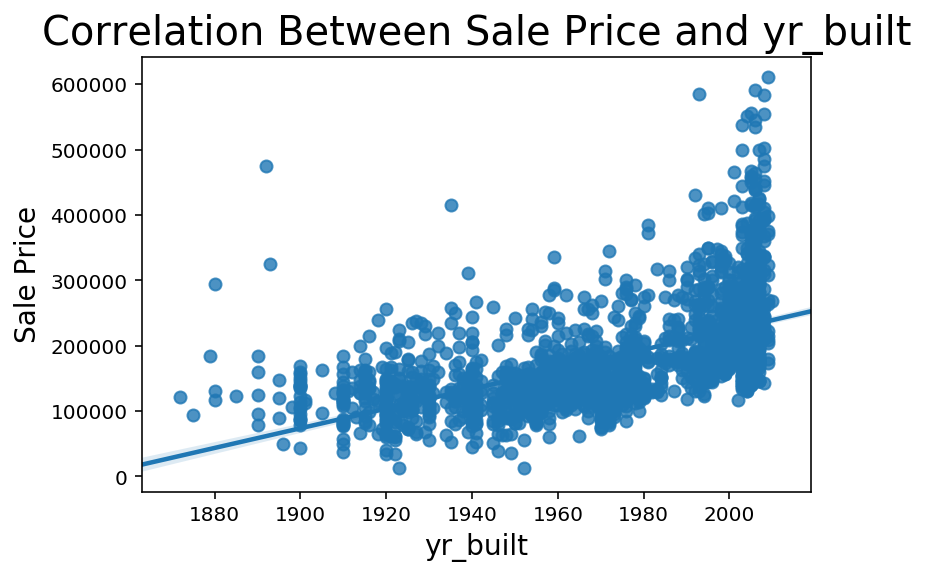

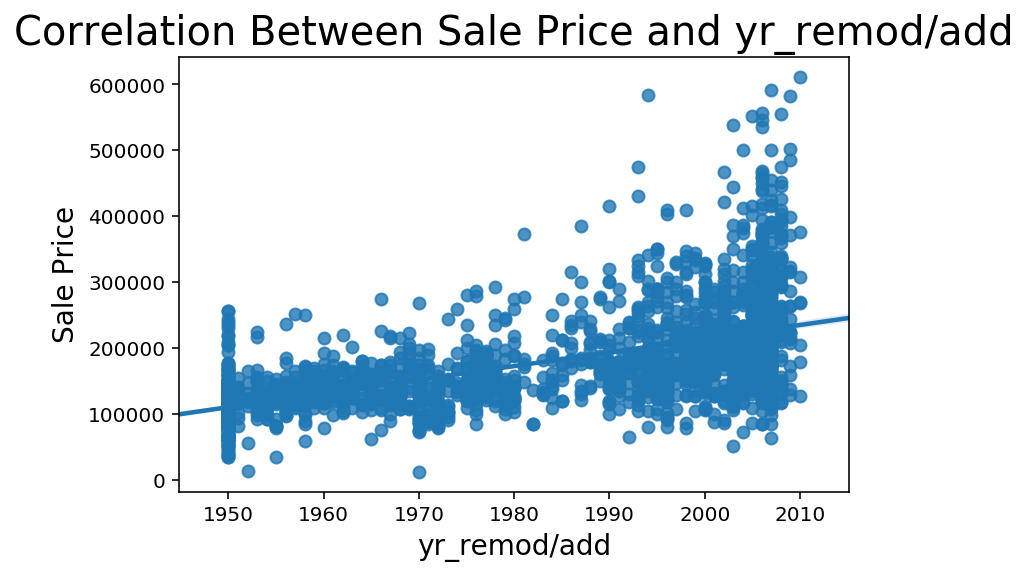

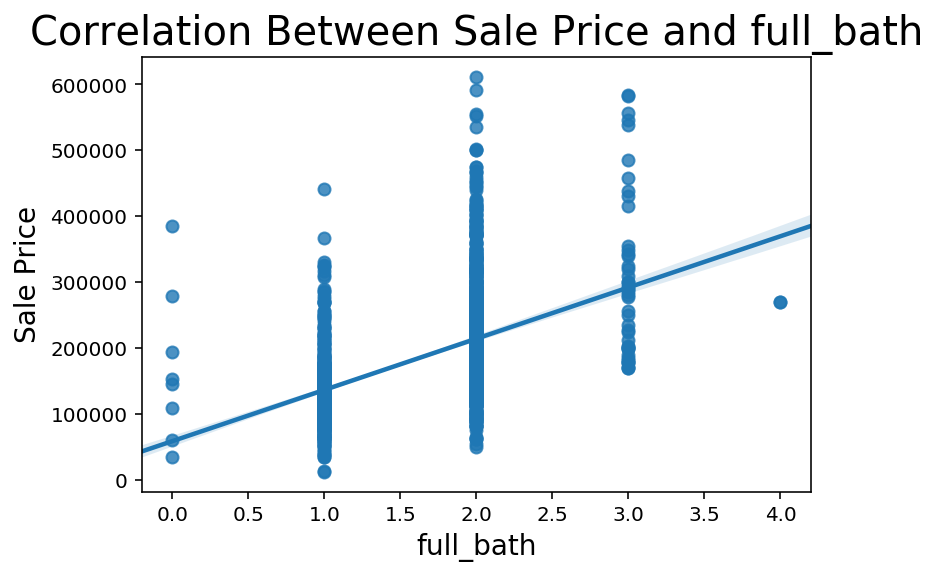

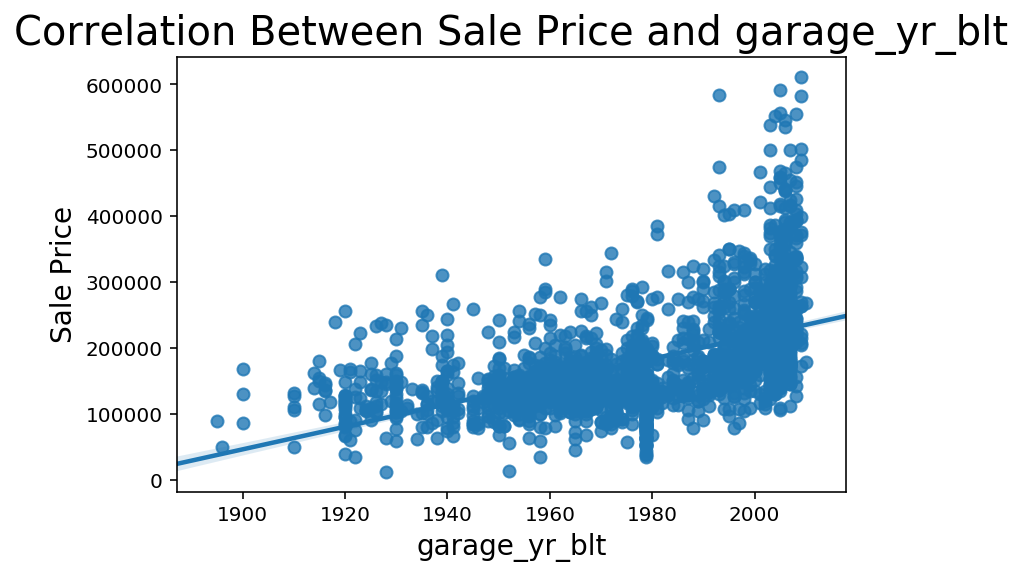

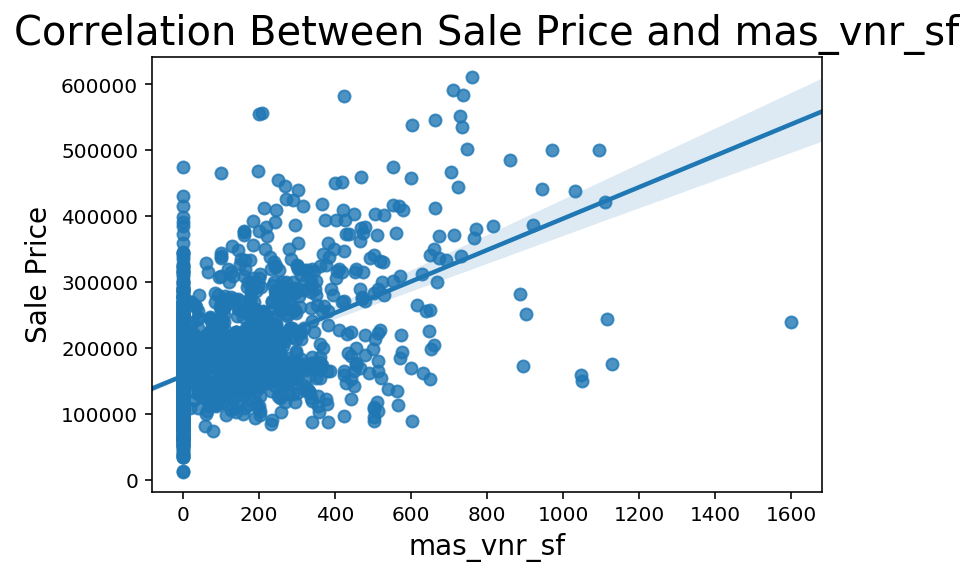

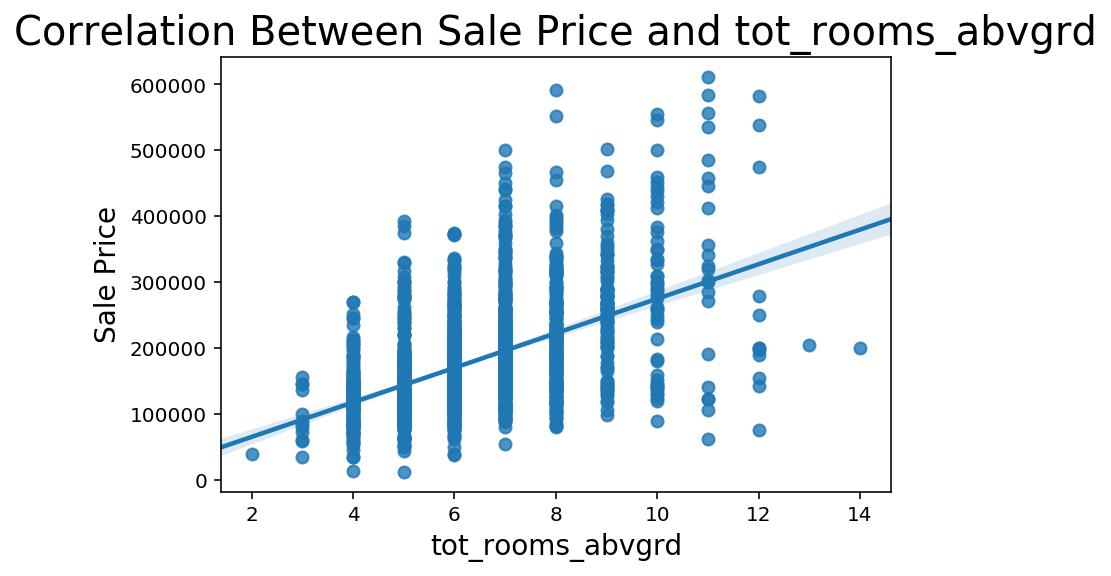

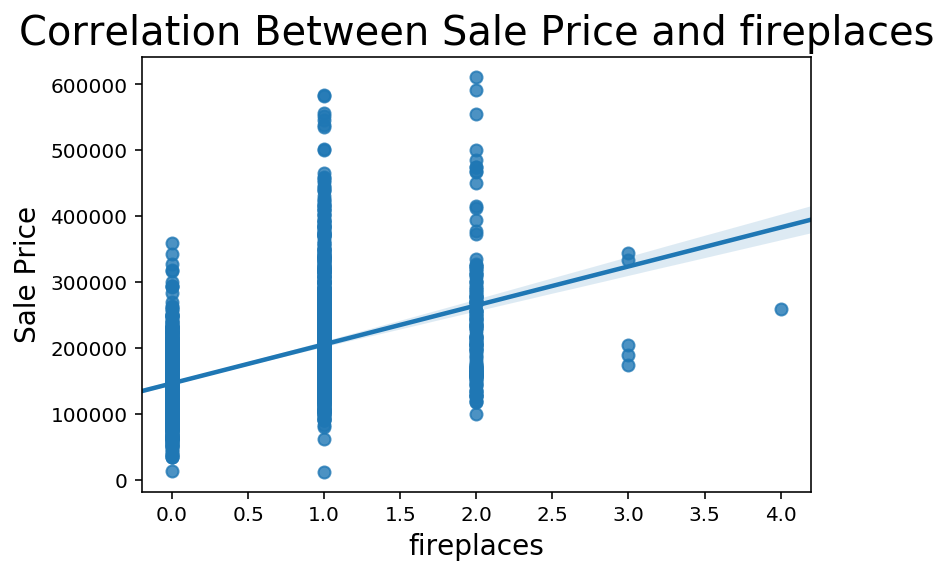

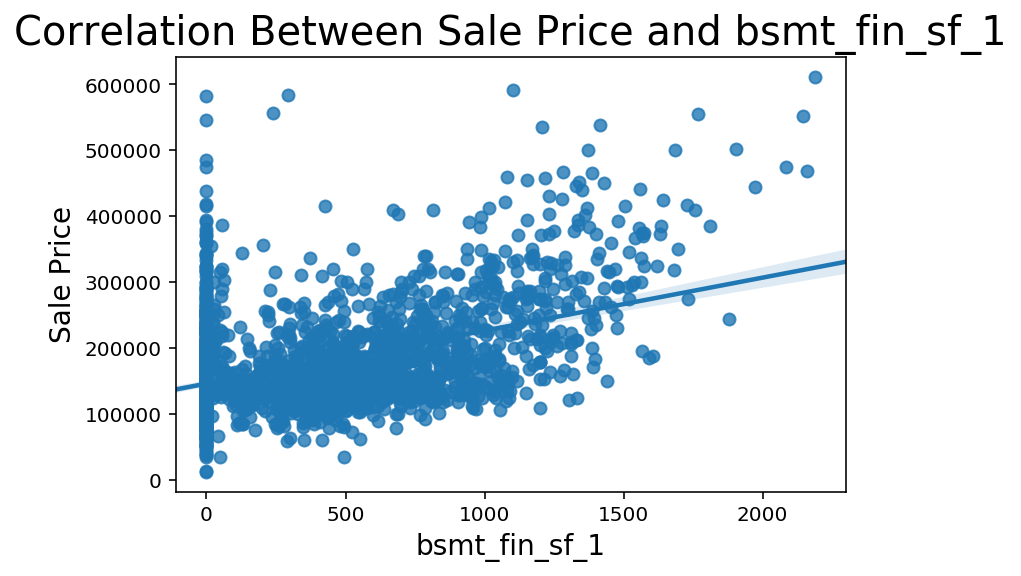

In [38]:
plt.figure()

for columns in high_corr_df:
    
    
    sns.regplot(x=columns, y="saleprice", data=high_corr_df);
    plt.title(f"Correlation Between Sale Price and {columns}", fontsize =20)
    plt.ylabel("Sale Price", fontsize = 14)
    plt.xlabel(columns, fontsize = 14)

    plt.show()
 

**Average Sale Price Per Neighborhood**

/Users/rwilkening/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


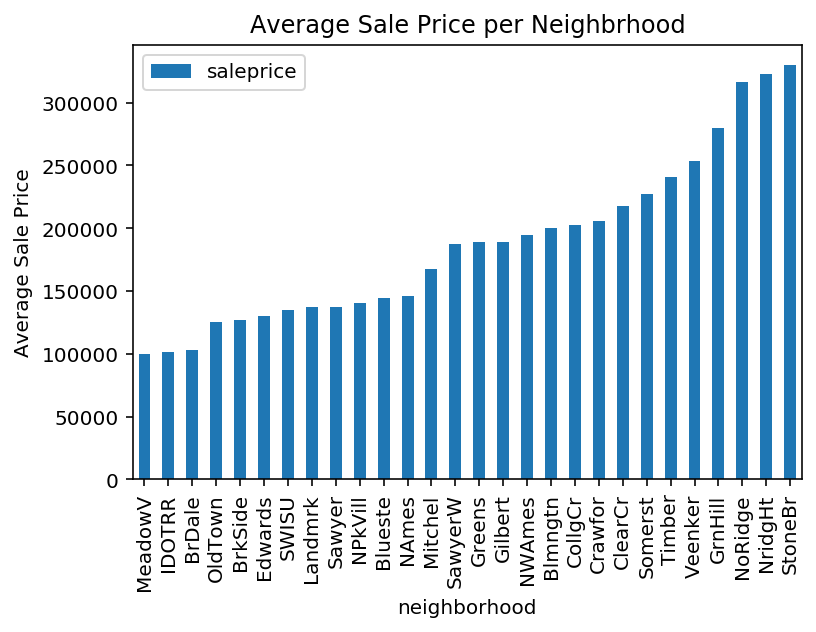

In [39]:
train.groupby('neighborhood')['neighborhood', 'saleprice'].mean().sort_values('saleprice').plot(kind ='bar');

plt.ylabel('Average Sale Price');
plt.title('Average Sale Price per Neighbrhood');

**Getting Dummis Neighborhood Column**

In [40]:
train = pd.get_dummies(train, columns = ['neighborhood'], prefix = None)
train.head()

id        pid  ms_subclass ms_zoning  lot_frontage_sf  lot_sf street  \
0  109  533352170           60        RL          69.0552   13517   Pave   
1  544  531379050           60        RL          43.0000   11492   Pave   
2  153  535304180           20        RL          68.0000    7922   Pave   
3  318  916386060           60        RL          73.0000    9802   Pave   
4  255  906425045           50        RL          82.0000   14235   Pave   

  alley lot_shape land_contour  ... neighborhood_NoRidge neighborhood_NridgHt  \
0   NaN       IR1          Lvl  ...                    0                    0   
1   NaN       IR1          Lvl  ...                    0                    0   
2   NaN       Reg          Lvl  ...                    0                    0   
3   NaN       Reg          Lvl  ...                    0                    0   
4   NaN       IR1          Lvl  ...                    0                    0   

  neighborhood_OldTown neighborhood_SWISU neighborhood_Sawyer  \
0                    0                  0                   1   
1                    0                  0                   0   
2                    0                  0                   0   
3                    0                  0                   0   
4                    0                  0                   0   

  neighborhood_SawyerW neighborhood_Somerst  neighborhood_StoneBr  \
0                    0                    0                     0   
1                    1                    0                     0   
2                    0                    0                     0   
3                    0                    0                     0   
4                    1                    0                     0   

   neighborhood_Timber  neighborhood_Veenker  
0                    0                     0  
1                    0                     0  
2                    0                     0  
3                    1                     0  
4                    0                     0  

[5 rows x 108 columns]

**Extracting the Dummied Neighborhood Columns in a Variable Called `neigh`**

In [41]:
neigh = []

for cols in train.columns:
    if 'neighborhood' in cols:
        neigh.append(cols)

**Viewing Columns Highly Correlated to Sale Price Grouped by Similarities** 

(Will display in multiple groups if it has multiple similarities)

In [42]:
group_prefixes(high_corr_df, high_corr_cols, prefixes) #Function defined above to group by similarities 

total_bsmt_sf
bsmt_fin_sf_1
___
gr_liv_sf
total_bsmt_sf
garage_sf
1st_flr_sf
mas_vnr_sf
bsmt_fin_sf_1
___
garage_sf
garage_cars
garage_yr_blt
___
___
___
saleprice
___
___
full_bath
___
overall_qu
___
___
___
___
___
tot_rooms_abvgrd
___
tot_rooms_abvgrd
___
yr_built
yr_remod/add
garage_yr_blt
___
Number of columns NOT grouped: 1
Columns that are NOT grouped:
___


['fireplaces']

## <span style = 'color:blue' > Preprocessing </span>
---
---

**Interation Columns from High Correlation Columns** 

**`garage_score`** = `garage_sf` x `garage_cars` x `garage_yr_blt`

**`yr_score`** = `yr_built` x `yr_remod/add` x`garage_yr_blt`

**`bsmt_score`** = `total_bsmt_sf` x `bsmt_fin_sf_1` 


**Tested Interation Variables that Don't Improve R2 Score:**

**`r_sf_score`** = `gr_liv_sf` * `1st_flr_sf` * `mas_vnr_sf`

In [43]:
train['garage_score'] = train['garage_sf'] * train['garage_cars'] * train['garage_yr_blt']
train['yr_score'] = train['yr_built'] * train['yr_remod/add'] * train['garage_yr_blt']
train['bsmt_score'] = train['total_bsmt_sf'] * train['bsmt_fin_sf_1'] 

#Potential Interaction terms: 
train['r_sf_score'] = train['gr_liv_sf'] * train['1st_flr_sf'] * train['mas_vnr_sf'] #Doesn't help R2 score and left out of submission

**Extracting Variables that I didn't use in interation terms**

In [44]:
high_cols = high_corr_df.drop(columns = ['saleprice']).columns

used_cols = ['garage_sf', 'garage_cars', 'garage_yr_blt', 'yr_built', 'yr_remod/add', 'garage_yr_blt', 'total_bsmt_sf', 'bsmt_fin_sf_1']

get_difference(high_cols, used_cols)


# Version 2 (Not as good):

# used_cols_2 = ['gr_liv_sf', '1st_flr_sf','mas_vnr_sf', 'garage_sf', 'garage_cars', 'garage_yr_blt', 'yr_built', 'yr_remod/add', 'garage_yr_blt', 'total_bsmt_sf', 'bsmt_fin_sf_1']
# get_difference(high_cols, used_cols_2)

['overall_qu',
 'fireplaces',
 'full_bath',
 'mas_vnr_sf',
 '1st_flr_sf',
 'tot_rooms_abvgrd',
 'gr_liv_sf']

## <span style = 'color: green'> HGTV Version </span>

**To get the same results as the HGTV presentation, run the commented out code below. Continue as normal for the Kaggle Compeition Version.**


In [45]:
train = train[train['saleprice'] < 350_000]


**Creating a DataFrame with Significant Columns and Interaction Terms**

In [46]:
sig_df = train[['fireplaces',
               'gr_liv_sf',
               'overall_qu',
               'mas_vnr_sf',
               'full_bath',
               'tot_rooms_abvgrd',
               '1st_flr_sf',
               'garage_score',
               'yr_score',
               'bsmt_score'
               ]]

# Version 2 (Not as good):

# sig_df_2 = train[['full_bath', 'overall_qu', 'fireplaces', 'tot_rooms_abvgrd', 'gr_liv_sf', '1st_flr_sf','mas_vnr_sf', 'garage_sf', 'garage_cars', 
# 'garage_yr_blt', 'yr_built', 'yr_remod/add', 'garage_yr_blt', 'total_bsmt_sf', 'bsmt_fin_sf_1']]

# Version 3 (Not as good):
# sig_cols = train[['overall_qu', 'gr_liv_sf', 'total_bsmt_sf', 'garage_sf', 'garage_cars', '1st_flr_sf', 'yr_built', 'full_bath', 'tot_rooms_abvgrd']]

**Creating a List with Highly Correlated Columns and NeighborHoods**


In [47]:
# neigh #] + train[high_cols]
high_w_neigh = []

for cols in high_cols:
    high_w_neigh.append(cols) 
    
for cols in neigh:
    high_w_neigh.append(cols)
    
sig_df = train[high_w_neigh]

# <span style = 'color:blue'> Modeling </span> 

--- 
---

## **Linear Regression**

### Setting up X and y variables

In [50]:
X = sig_df   
features = list(X.columns)
y = train['saleprice']

# Version 2 (Not as Good):

# # X_2 = sig_df_2
# features_2 = list(X.columns)
# y_2 = train['saleprice']

### Train/Test/Split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Version 2 (Not as good):
# X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, random_state=42)

### Instantiating the Model:

In [52]:
lr = LinearRegression()

### Fitting to Model

In [53]:
lr.fit(X_train, y_train)

# Version 2 (Not as good):
# lr.fit(X_2_train, y_2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Coefficient

In [54]:
lr.coef_

array([ 1.24861231e+04,  4.47226510e+01,  1.12108056e+01,  3.38110127e+01,
       -5.94765417e+02,  6.39469636e+00,  2.44343302e+02,  3.26200582e+02,
       -2.30614095e+03,  8.99310373e+00,  3.74837526e+00, -1.02528288e+03,
        7.89831946e+03,  1.99520306e+01, -6.80167733e+03, -2.68435425e+04,
       -2.62590065e+04,  2.30711332e+03,  2.03480430e+04,  6.61436364e+02,
        1.62528177e+04, -7.85088917e+03, -3.06242028e+03, -3.14490502e+04,
        9.27859546e+04, -6.65380184e+03, -2.47124285e+04, -2.17563053e+04,
       -5.55048652e+03, -3.63068170e+03, -2.16634339e+04, -5.42668588e+03,
        2.90720366e+04,  2.69615228e+04, -8.51454335e+03, -1.11445289e+04,
       -5.42784776e+03, -5.38355050e+03,  1.01171987e+04,  7.39137264e+03,
        1.02045093e+04,  6.02887513e+03])

### Intercept

In [55]:
lr.intercept_

-1150853.181254428

### Average R2 Scores:

**Avg. R2 for the Cross Valdition of `X_test` and `y_test` Model:**

In [56]:
cross_val_score(lr, X_train, y_train, cv=5).mean() #R2 score

# Version 2 (Not as good):
# cross_val_score(lr, X_2_train, y_2_train, cv=5).mean()

0.8788047323795418

**Getting the R2 Scores for `X_train` and `y_train` Model:**

In [58]:
lr.score(X_train, y_train)

0.8869946506645345

**R2 Scores for `X_test` and `y_test` Model:**

In [59]:
lr.score(X_test, y_test)

0.8616431618323532

**Predictions:**

In [60]:
predictions = lr.predict(X_train)
predictions.mean()

170983.31296673435

**Root Mean Squared Error (RMSE)**

In [61]:
np.sqrt(mean_squared_error(y_train, predictions))

20564.494334879342

**R2 score from `y_test`**

In [62]:
r2_score(y_train, predictions)

0.8869946506645345

**Linear Regression Plot for Actual Prices vs. Predicted Prices**

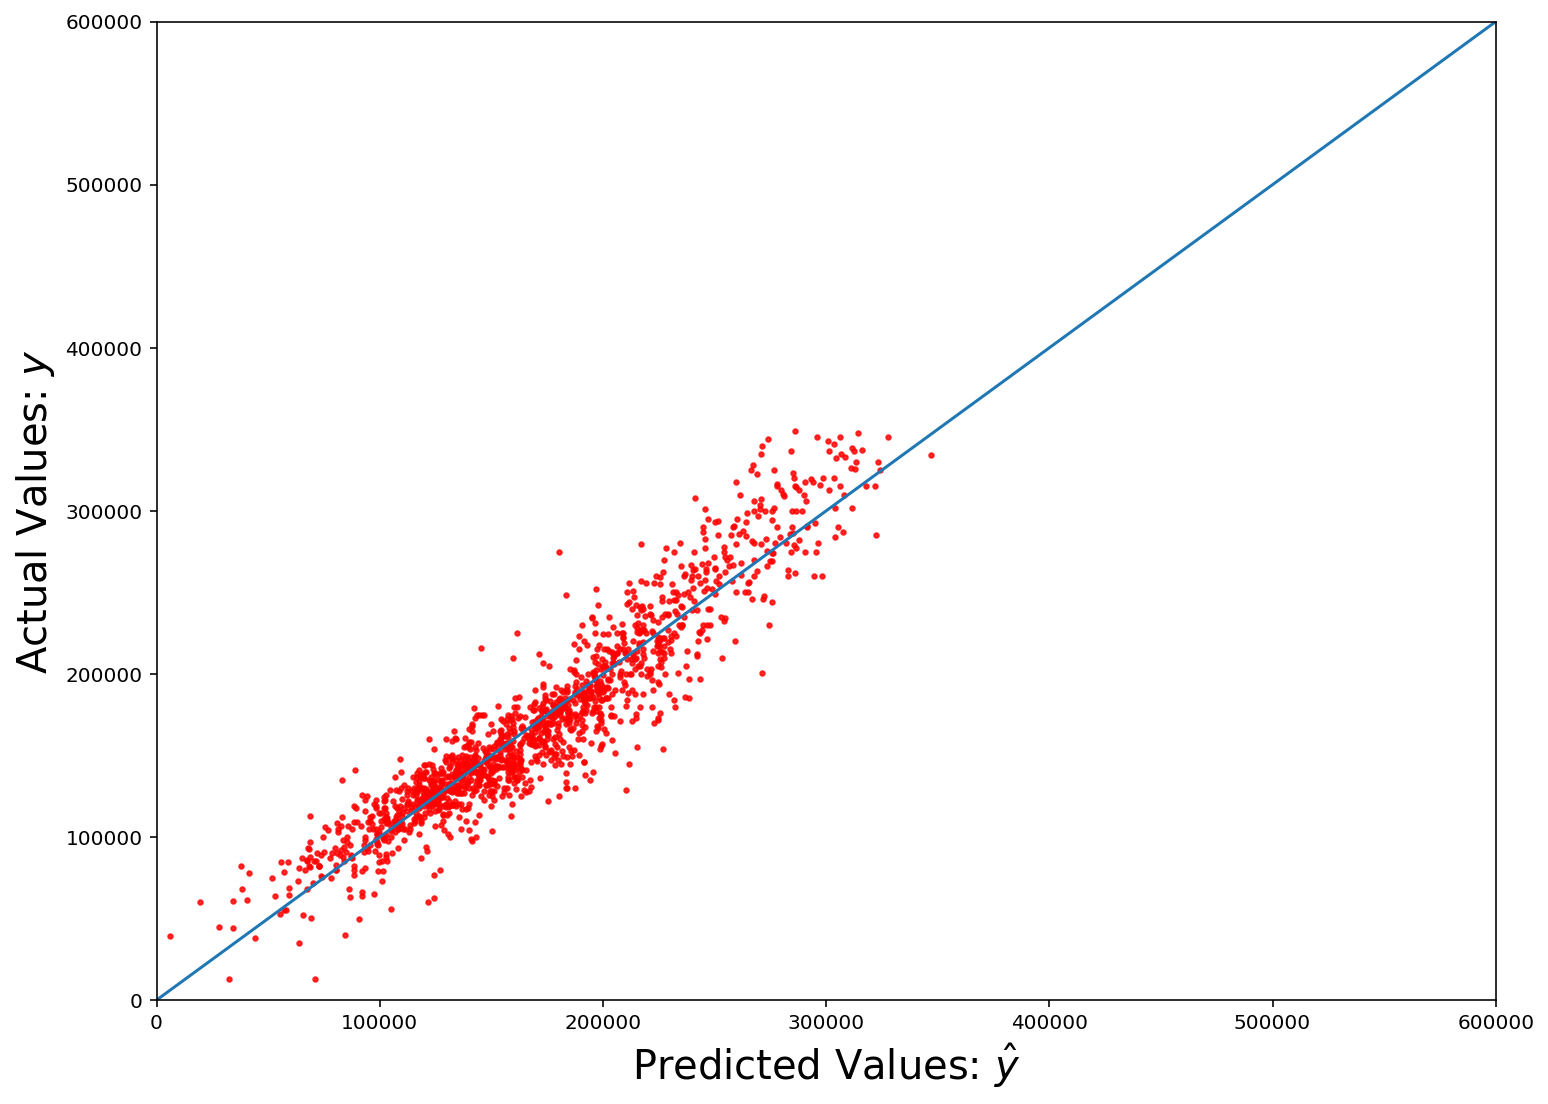

In [63]:
# Code from 3.01-lesson-linear_regression 
# Plot the model

plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.

plt.scatter(predictions, y_train, s=5, color='red', alpha = 0.8)
plt.xlim((0,600_000))
plt.ylim((0,600_000))
# Plot a line.

plt.plot([0, 600_000],[0, 600_000])

# Tweak title and axis labels.

plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20);
# plt.title('Linear Model Predicted Values vs. Actual Values', fontsize = 24);

# **Standard Scaler**

In [64]:
# Instantiate Standard Scaler.

ss = StandardScaler()

# Fit AND transform Standard Scaler to overfit data in one step.

Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

### **Standard Scaler with Linear Regression**

In [65]:
ols = LinearRegression()

In [66]:
ols.fit(Z_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
ols.fit(Z_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
np.sqrt(mean_squared_error(y_train, predictions))

20564.494334879342

## **Ridge** 

In [69]:
# Instantiate.
ridge = Ridge(alpha = 10)

# Fit.
ridge.fit(Z_train, y_train)

# Evaluate model using R2.
ridge_train = ridge.score(Z_train, y_train)
ridge_test = ridge.score(Z_test, y_test)

print(f"train: {ridge_train}, test: {ridge_test}")

train: 0.8869654968938594, test: 0.8617122406953684


In [71]:
alphas_ridge = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(
    alphas = alphas_ridge,
    scoring = "r2",
    cv=5)

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

## **LASSO**

In [72]:
lr.fit(Z_train, y_train)

lasso_train = lr.score(Z_train, y_train)
lasso_test = lr.score(Z_test, y_test)

print(f"train: {lasso_train}, test: {lasso_test}")

train: 0.8869944680302606, test: 0.8616504610137692


## **Coefficients**

In [73]:
ridge_cv.coef_

array([16386.81352755, 19486.98203244,  4462.12284572,  6621.42569581,
        -160.32020001,  2431.6037498 ,  7095.36196221,  6836.66544658,
       -1080.69610627,   326.16083347,   620.9194202 , -1177.27029491,
        5105.10663629,  8144.46323105,  -629.37616383, -1506.16628508,
       -2637.42033886,   534.53879569,  2297.49205577,   382.33877386,
        2881.90715519, -1842.05848054,  -579.47967187,  -786.60281483,
        3428.82965953, -1127.05125992,  -617.55339665, -2422.31708509,
        -971.3046541 , -1186.24302934, -2048.54050453,  -984.4068228 ,
        4234.85271884,  5421.86996736, -2194.25350568, -1331.76271225,
       -1138.75067422,  -992.69141093,  2712.67802341,   857.16470219,
        1605.83201496,   514.94168746])

In [74]:
lr.coef_

array([ 1.65041183e+04,  2.00878302e+04,  4.45889373e+03,  6.82207095e+03,
       -4.30549150e+02,  2.29400920e+03,  7.30783858e+03,  6.84208101e+03,
       -1.24641340e+03,  2.13502661e+02,  5.59903023e+02, -1.50005530e+03,
        5.02282462e+03,  8.17582636e+03,  1.02835020e+15,  6.16449353e+14,
        1.09859885e+15,  2.07826097e+15,  1.16444001e+15,  3.03757906e+15,
        1.82397857e+15,  2.65375200e+15,  2.45776376e+15,  2.76059868e+14,
        3.90274976e+14,  1.90065112e+15,  2.76059868e+14,  1.22658366e+15,
        2.02688127e+15,  3.97227908e+15,  1.02835020e+15,  2.14451556e+15,
        1.49707364e+15,  2.09505813e+15,  2.91025070e+15,  1.34180432e+15,
        2.41608105e+15,  2.27013954e+15,  2.65375200e+15,  1.09859885e+15,
        1.59154611e+15,  8.25926050e+14])

**Pickleing to Kaggle File**

In [75]:
file_name = 'kag_sub'
pickle.dump(lr, open(file_name, 'wb'))